In [10]:
import sys
sys.path.append('../')

import numpy as np
import pylab as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import lightning as L
from sklearn import datasets

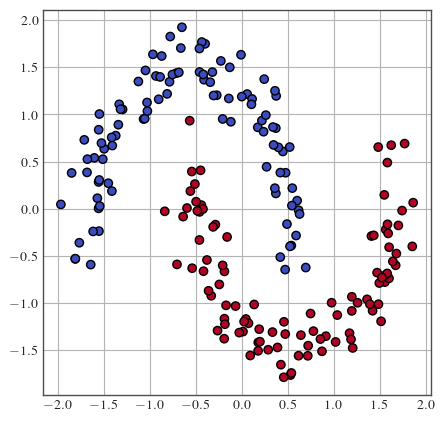

In [11]:
X, y = datasets.make_moons(200, noise=.1, random_state=42)
y %= 2
X = (X - X.mean(0)) / X.std(0)
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).long()

train_ds = torch.utils.data.TensorDataset(X, y)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [12]:
class Net(nn.Module):
    def __init__(self, num_classes: int, dropout_rate: int = .2, feature_dim: int = 128):
        super().__init__()

        self.first = nn.Linear(2, feature_dim)
        self.first_dropout = nn.Dropout(dropout_rate)
        self.hidden = nn.Linear(feature_dim, feature_dim)
        self.hidden_dropout = nn.Dropout(dropout_rate)
        self.last = nn.Linear(feature_dim, num_classes)
        self.act = nn.ReLU()

    def forward(self, x, return_features=False):
        x = self.act(self.first(x))
        x = self.first_dropout(x)
        x = self.act(self.hidden(x))
        x = self.hidden_dropout(x)
        out = self.last(x)
        if return_features:
            return out, x
        return out

    def get_logits(self, dataloader, device):
        self.to(device)
        self.eval()
        all_logits = []
        for samples, _, indices in dataloader:
            logits = self(samples.to(device))
            all_logits.append(logits)
        logits = torch.cat(all_logits)
        return logits

In [13]:
def dataset_to_xy(dataset):
    X, y = [], []
    for batch in dataset:
        X.append(batch[0])
        y.append(batch[1])
    X = torch.stack(X).float()
    y = torch.Tensor(y).long()
    return X, y

@torch.no_grad()
def plot_contour(model, dataset, unlabeled_indices, labeled_indices, ax=None):
    X, y = dataset_to_xy(dataset)

    model.eval()
    model.cpu()
    if ax:
        plt.sca(ax)
    domain = 5
    xx, yy = torch.meshgrid(torch.linspace(-domain, domain, 51), torch.linspace(-domain, domain, 51))
    zz = torch.stack((xx.flatten(), yy.flatten()), dim=1)

    logits = model(zz)
    probas = logits.softmax(-1)
    zz = probas[:, 1].view(xx.shape)

    # plt.title(f"Ep {}")
    plt.scatter(X[unlabeled_indices, 0], X[unlabeled_indices, 1], s=1)
    plt.scatter(X[labeled_indices, 0], X[labeled_indices, 1], c=y[labeled_indices], s=100)
    plt.contourf(xx.numpy(), yy.numpy(), zz.numpy(), alpha=.8, zorder=-1, levels=np.linspace(0, 1, 6))
    plt.colorbar()

Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)


`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


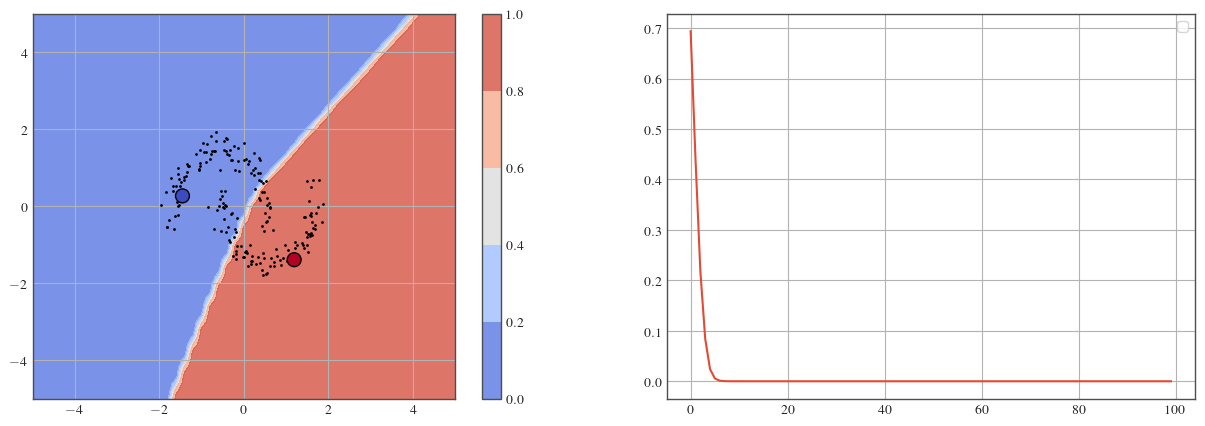

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


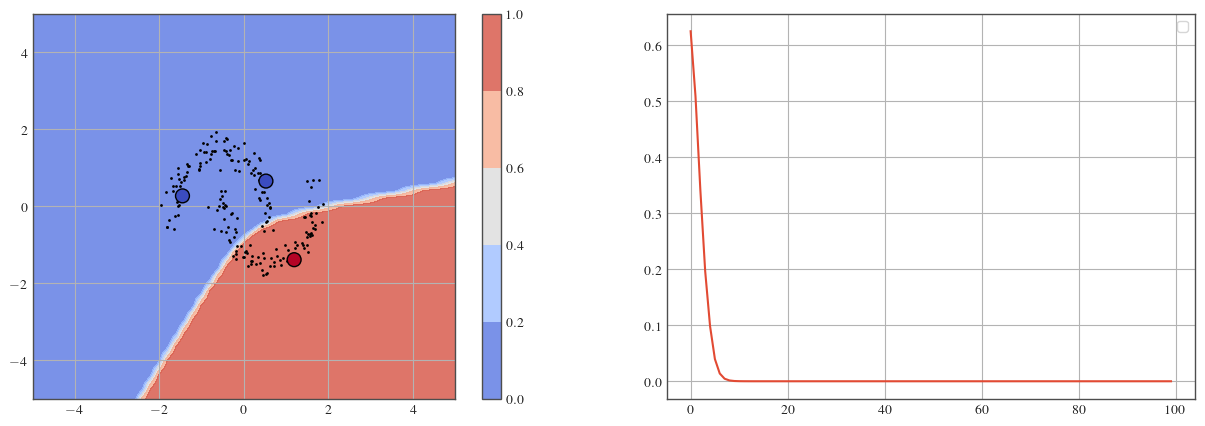

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


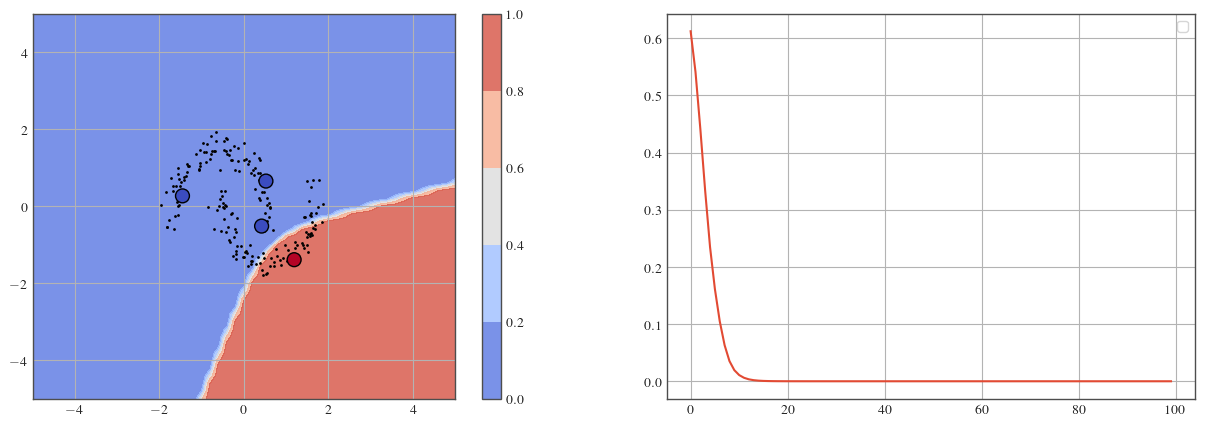

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Net              | 17.2 K
1 | loss_fn       | CrossEntropyLoss | 0     
2 | train_metrics | ModuleDict       | 0     
3 | val_metrics   | ModuleDict       | 0     
---------------------------------------------------
17.2 K    Trainable params
0         Non-trainable params
17.2 K    Total params
0.069     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=100` reached.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


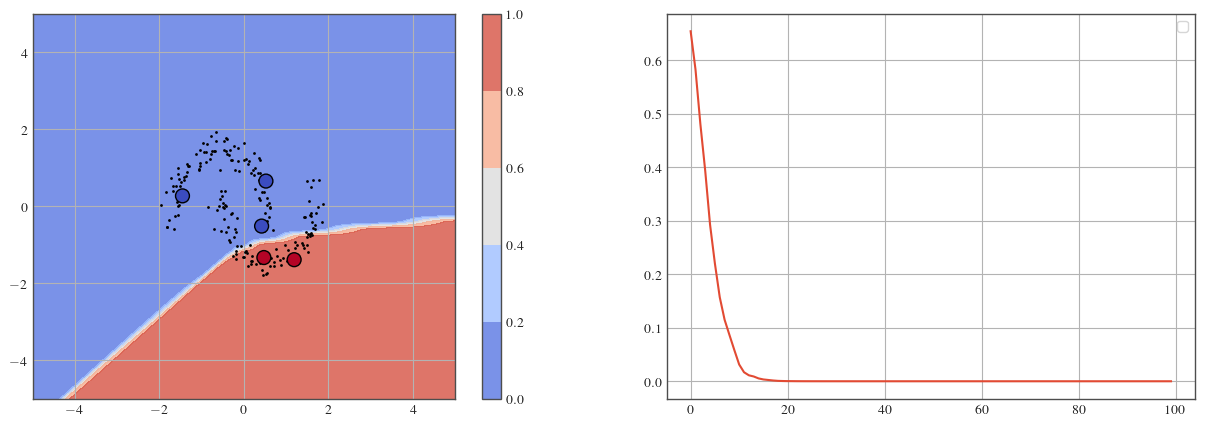

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
from dal_toolbox.active_learning import ActiveLearningDataModule
from dal_toolbox.models.deterministic import DeterministicModel
from dal_toolbox.models.utils.callbacks import MetricHistory
from dal_toolbox.active_learning.strategies import EntropySampling
from dal_toolbox.utils import seed_everything

# Train args
seed_everything(0)
torch.manual_seed(0)
dropout_rate = 0.0
epochs = 100
n_cycles = 10

# AL Setup
al_datamodule = ActiveLearningDataModule(train_ds, train_batch_size=32)
al_datamodule.random_init(2, class_balanced=True)
al_strat = EntropySampling()

model = Net(dropout_rate=dropout_rate, num_classes=2)
model = DeterministicModel(model, optimizer=torch.optim.SGD(model.parameters(), lr=1e-1, momentum=.9))
    
for i_cycle in range(n_cycles):
    if i_cycle != 0:
        indices = al_strat.query(model=model, al_datamodule=al_datamodule, acq_size=1)
        al_datamodule.update_annotations(indices)
    

    history = MetricHistory()
    model.reset_states()
    trainer = L.Trainer(max_epochs=epochs, callbacks=[history], enable_progress_bar=False)
    trainer.fit(model, al_datamodule)

    plt.figure(figsize=(15, 5))
    plt.subplot(122)
    plt.plot([d[f'train_loss'] for d in history])
    plt.legend()
    plot_contour(model, al_datamodule.query_dataset, al_datamodule.unlabeled_indices, al_datamodule.labeled_indices, ax=plt.subplot(121))
    plt.show()